In [136]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [137]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np

### Exploratory Data Analysis

In [138]:
#load reviews
reviews=pd.read_csv("reviews_clean.csv")
reviews=reviews.dropna()

In [139]:
#load recipes
recipes=pd.read_csv("recipes_clean.csv")

#Convert ingredient and ingredient strings into ingredient lists
recipes["Ingredients_clean"]=recipes["Ingredients_clean"].apply(eval)
recipes["Ingredients_clean"]=recipes["Ingredients_clean"].apply(lambda x : list(set(x)))
recipes["Instructions"]=recipes["Instructions"].apply(lambda x : simple_preprocess(" ".join(eval(x))))

In [140]:
recipes.head()

,Recipe_ID,Recipe_name,Rating,Prepare_time,Ingredients,Ingredients_clean,Instructions
0,6664,"Basil, Roasted Peppers and Monterey Jack Cornb...",4.468085,100,"['1/2 cup unsalted butter, chilled and cubed',...","[basil, cheese, baking soda, unsalted, egg, ma...","[preheat, oven, to, degrees, degrees, butter, ..."
1,6663,Crispy Cheese Twists,4.431818,0,"['1/2 cup parmesan cheese', '3/4 teaspoon grou...","[black pepper, puff, egg, parmesan cheese, gar...","[combine, parmesan, cheese, pepper, and, garli..."
2,6665,Mom's Yeast Rolls,3.598837,0,"['2 cups hot water', '1/2 cup margarine', '1/3...","[egg, margarine, flour, white sugar, salt, dry...","[melt, margarine, in, hot, water, add, sugar, ..."
3,6666,Sweet Potato Bread I,4.707865,0,"['1 1/2 cups white sugar', '1/2 cup vegetable ...","[pecan, vegetable oil, potato, cinnamon, egg, ...","[combine, sugar, and, oil, beat, well, add, eg..."
4,6668,Orange Buns,4.666667,170,"['1/4 cup butter', '1 teaspoon white sugar', '...","[bread, butter, egg, orange juice, orange zest...","[stir, butter, and, teaspoon, sugar, into, the..."


In [141]:
recipes["Ingredients_clean"][0]

['basil',
 'cheese',
 'baking soda',
 'unsalted',
 'egg',
 'marinated red bell',
 'flour',
 'corn',
 'white sugar',
 'salt',
 'buttermilk',
 'onion',
 'cornmeal',
 'baking powder']

In [142]:
#train_test_split
from sklearn.model_selection import train_test_split

#### How are ratings from 1 to 5 distributed ?

In [143]:
#Number of reviews for each recipe
review_count=reviews.groupby("Recipe_ID").size()

#mean rating for each recipes
ratings_mean=reviews.groupby("Recipe_ID")["Rating"].mean()

#Number of ratings for each star-category
ratings_count=pd.DataFrame(reviews.groupby("Rating").size(),columns=["Count"]).reset_index()

#Number of reviews for each user
user_review_count=reviews.groupby("Reviewer_ID").size()

#Mean rating for each user
user_mean_rating=reviews.groupby("Reviewer_ID")["Rating"].mean()

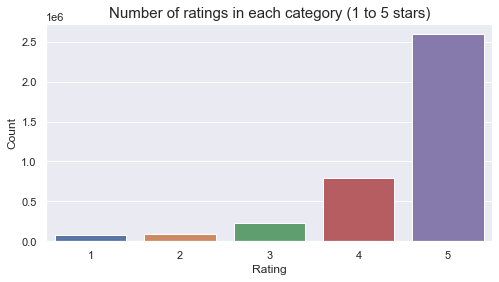

In [144]:
fig,ax=plt.subplots(figsize=(8,4))
sns.barplot(ratings_count["Rating"],ratings_count["Count"]);
ax.set_title("Number of ratings in each category (1 to 5 stars)",fontsize=(15));

In [145]:
ratings_count[ratings_count["Rating"]==5]["Count"].sum()

2595406

In [146]:
ratings_count[ratings_count["Rating"]<4]["Count"].sum()/len(reviews)

0.10631466710042121

In [147]:
reviews.groupby("Reviewer_ID").size()

Reviewer_ID
16          18
21           7
22          27
26           1
32          82
            ..
23459550     1
23460007     1
23460332     1
23460398     1
23463743     1
Length: 1158858, dtype: int64

#### Distribution of the number of reviews per user

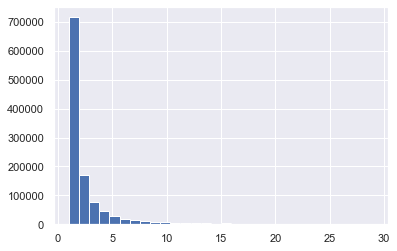

In [148]:
plt.hist(user_review_count[user_review_count<30],bins=30);

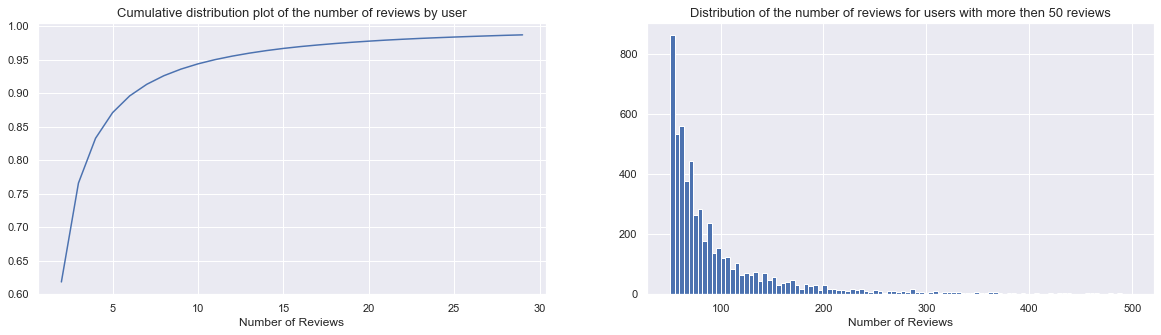

In [149]:
fig,axes=plt.subplots(1,2,figsize=(20,5))

axes[0].plot([i for i in range(2,30)],[len(user_review_count[user_review_count<i])/len(user_review_count)  for i in range(2,30)]);
axes[0].set_title("Cumulative distribution plot of the number of reviews by user",fontsize=13);
axes[0].set_xlabel("Number of Reviews",fontsize=12);

axes[1].hist(user_review_count[(user_review_count>50) & (user_review_count<500)],bins=100);
axes[1].set_title("Distribution of the number of reviews for users with more then 50 reviews",fontsize=13);
axes[1].set_xlabel("Number of Reviews",fontsize=12);


#### Do somes user tend to be more severe than others ?

In [150]:
#Creating a reviews table containing number 1,2,3,4,5 ratings for each user
users=pd.DataFrame(reviews["Reviewer_ID"].unique(),columns=["Reviewer_ID"])
users[1]=1

ratings=pd.DataFrame(reviews["Rating"].unique(),columns=["Rating"])
ratings[1]=1

reviews_table=pd.merge(users,ratings,on=1).drop(1,axis=1)
reviews_table=pd.merge(reviews_table,reviews.groupby(["Reviewer_ID","Rating"]).size().reset_index(),on=["Reviewer_ID","Rating"],how="left").fillna(0)
reviews_table=reviews_table.rename(columns={0 : "Counts"})

In [151]:
reviews_table=reviews_table[reviews_table["Reviewer_ID"].isin(user_review_count[user_review_count>20].index)]

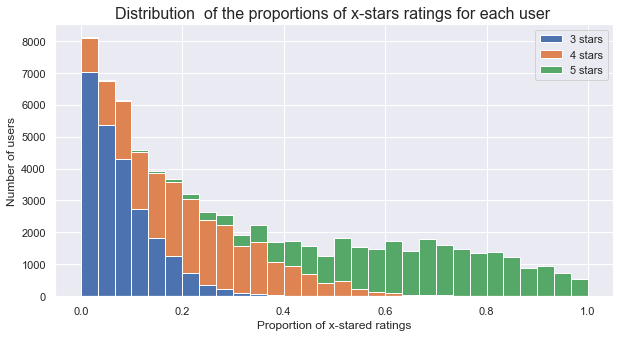

In [152]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
rating_dist=[(reviews_table[reviews_table["Rating"]==i].groupby("Reviewer_ID")["Counts"].sum()/reviews_table.groupby("Reviewer_ID")["Counts"].sum()) for i in range(3,6)]
ax.hist(rating_dist, label=["3 stars","4 stars","5 stars"],stacked=True,bins=30,rwidth=500);
ax.legend();
ax.set_xlabel("Proportion of x-stared ratings",fontsize=12);
ax.set_ylabel("Number of users",fontsize=12);
ax.set_title("Distribution  of the proportions of x-stars ratings for each user ",fontsize=16);

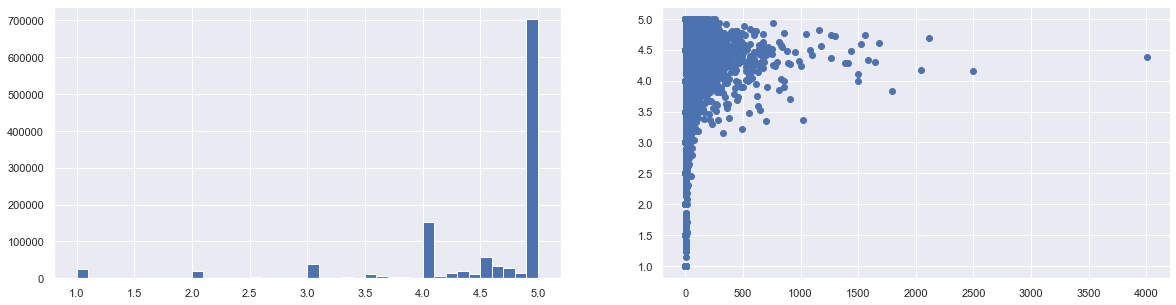

In [153]:
fig,axes=plt.subplots(1,2,figsize=(20,5))
axes[0].hist(user_mean_rating,bins=40);
axes[1].scatter(user_review_count,user_mean_rating);

In [154]:
review_count_cut=review_count[review_count.between(review_count.quantile(0),review_count.quantile(0.8))]
ratings_cut=ratings_mean[review_count.between(review_count.quantile(0),review_count.quantile(0.8))]

In [155]:
reviews_table

,Reviewer_ID,Rating,Counts
5,11174581,5,37.0
6,11174581,2,0.0
7,11174581,4,4.0
8,11174581,3,1.0
9,11174581,1,0.0
...,...,...,...
4290325,1027825,5,3.0
4290326,1027825,2,3.0
4290327,1027825,4,13.0
4290328,1027825,3,11.0


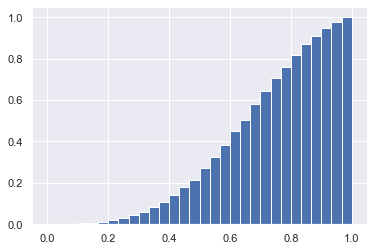

In [156]:
under5=reviews_table[reviews_table["Rating"]>4].groupby("Reviewer_ID")["Counts"].sum()/reviews_table.groupby(["Reviewer_ID"])["Counts"].sum()
plt.hist(under5,bins=30,cumulative=True,density=True);

#### Is the average rating of a recipe correlated to its number of reviews ?

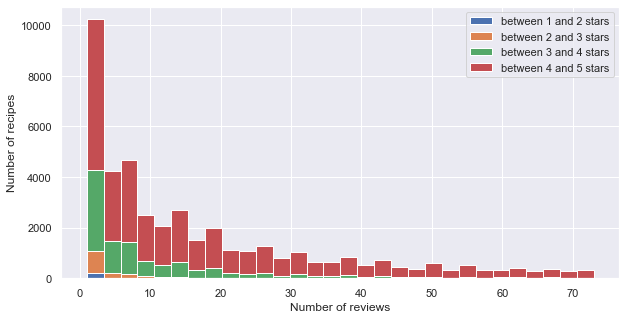

In [157]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
classes=[review_count_cut[ratings_cut.between(i,i+1)] for i in np.linspace(1,4,4)]
ax.hist(classes, label=["between 1 and 2 stars","between 2 and 3 stars","between 3 and 4 stars","between 4 and 5 stars"],stacked=True,bins=30);
#sns.scatterplot(review_count,ratings,ax=ax[1]);
ax.legend();
ax.set_xlabel("Number of reviews", fontsize=12);
ax.set_ylabel("Number of recipes",fontsize=12);

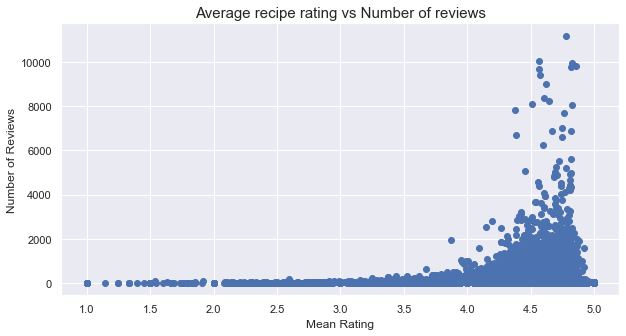

In [158]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
plt.scatter(ratings_mean,review_count);
ax.set_xlabel("Mean Rating", fontsize=12);
ax.set_ylabel("Number of Reviews",fontsize=12);
ax.set_title("Average recipe rating vs Number of reviews",fontsize=15);

#### What are the most popular recipes ? 

In [159]:
def plot_recipes(recipe_list) :
    images=[]
    labels=[]
    for recipe_ID in recipe_list :
        images.append("Images/{}.jpg".format(recipe_ID))
        labels.append(recipes[recipes["Recipe_ID"]==recipe_ID]["Recipe_name"].iloc[0]+" "+str(recipes[recipes["Recipe_ID"]==recipe_ID]["Rating"].iloc[0]))
        #labels.append(recipes.iloc[recipe_ID]["Recipe_name"])
          
    images=np.array(images)
    labels=np.array(labels)
    
    ipyplot.plot_images(images, labels=labels,max_images=100, img_width=150);
    
    return(images,labels)
    

def index_to_recipe_id(index_list) :
    id_list=[]
    for index in index_list :
        id_list.append(recipes["Recipe_ID"].iloc[index])
    return id_list

import ipyplot

def index_to_id(index_list) :
    id_list=[]
    for index in index_list :
        id_list.append(recipes["Recipe_ID"].iloc[index])
    return id_list

import ipyplot

In [218]:
plot_recipes(reviews.groupby("Recipe_ID").size().sort_values(ascending=False)[0:10].index);

#### The less popular recipes ? 

In [162]:
#Keep only recipes with more than 10 reviews
mask=reviews.groupby("Recipe_ID").size()[reviews.groupby("Recipe_ID").size()>5].index

In [163]:
(reviews[reviews["Recipe_ID"].isin(mask)].groupby("Recipe_ID")["Rating"].mean()<4).sum()

5081

In [253]:
plot_recipes(reviews[reviews["Recipe_ID"].isin(mask)].groupby("Recipe_ID")["Rating"].mean().sort_values(ascending=False)[-10:].index);

#### What are the most used ingredients ?

In [165]:
from gensim.corpora import Dictionary

#Define Dictionary of Ingredients
dictionary = Dictionary(recipes["Ingredients_clean"])

#Fiter Ingredients that appear in at least 10 recipes
dictionary.filter_extremes(no_below=20,no_above=1)

In [166]:
len(dictionary)

1028

In [167]:
#Define Ingredient matrix : one-hot encode which ingredient appears in which recipe
ingredient_matrix=gensim.matutils.corpus2dense([dictionary.doc2bow(recipe) for recipe in recipes["Ingredients_clean"]], num_terms=len(dictionary))
ingredient_matrix=ingredient_matrix.T
ingredient_matrix=pd.DataFrame(ingredient_matrix,index=recipes["Recipe_ID"],columns=list(dictionary.token2id.keys()))

In [168]:
ingredient_matrix.head()

,baking powder,baking soda,basil,buttermilk,cheese,corn,cornmeal,egg,flour,onion,...,flaxseed meal,aluminum,sunflower seed kernel,chia seed,spring,coconut flour,coconut water,sriracha sauce,vanilla protein powder,sriracha hot sauce
Recipe_ID,,,,,,,,,,,,,,,,,,,,,
6664,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6666,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
ingredient_count=ingredient_matrix.replace(0,np.nan).sum()
ingredient_count.sort_values(ascending=False)[:20]

salt                 16789.0
white sugar          11231.0
flour                10442.0
egg                  10173.0
water                 9286.0
butter                8535.0
milk                  7754.0
black pepper          7460.0
olive oil             7036.0
vanilla extract       6053.0
brown sugar           5101.0
vegetable oil         5061.0
cinnamon              4416.0
baking powder         3839.0
baking soda           3545.0
onion                 3459.0
salt pepper           3449.0
salt black pepper     3402.0
garlic                3277.0
lemon juice           3233.0
dtype: float32

#### Ingredient Ratings

In [170]:
ingredient_ratings=ingredient_matrix.multiply(recipes.set_index("Recipe_ID")["Rating"],axis=0).replace(0,np.nan).mean(axis=0)

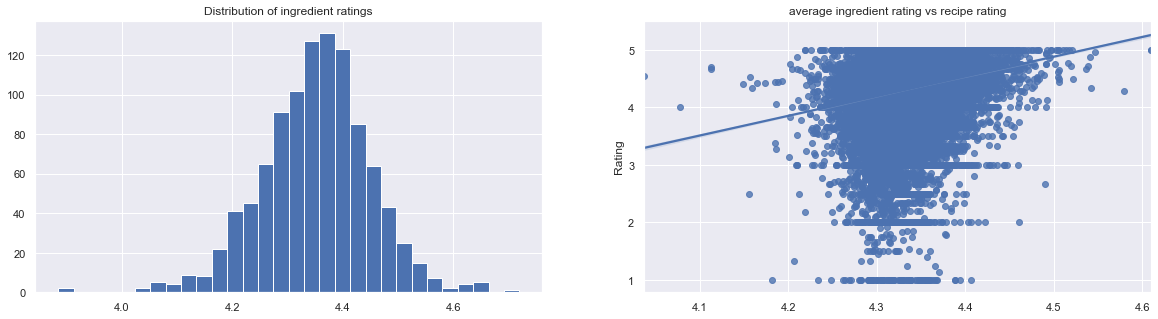

In [171]:
fig,ax=plt.subplots(1,2,figsize=(20,5));
ax[0].hist(ingredient_ratings,bins=30);
sns.regplot((ingredient_matrix*ingredient_ratings).replace(0,np.nan).mean(axis=1),recipes["Rating"],ax=ax[1]);

ax[0].set_title("Distribution of ingredient ratings");
ax[1].set_title("average ingredient rating vs recipe rating");

In [172]:
len(dictionary)

1028

In [173]:
ingredient_ratings.sort_values(ascending=False)[:20]

baguette                  4.719352
cotija cheese             4.658188
pistachio                 4.658009
food                      4.657588
sunflower seed kernel     4.654218
white balsamic vinegar    4.641584
orange bell pepper        4.611213
potato starch             4.609984
peach schnapps            4.609725
pomegranate seed          4.609121
creme fraiche             4.598002
crawfish tail             4.596176
bar chocolate             4.578948
espresso powder           4.578909
pickle                    4.576831
collard green             4.576454
de                        4.567447
lime wedge                4.565405
mexican oregano           4.565339
sweet italian             4.549538
dtype: float64

### User Segmentation

In [174]:
#Keep only users with more than 10 reviews
mask=reviews.groupby("Reviewer_ID").size()[reviews.groupby("Reviewer_ID").size()>10].index
reviews=reviews[reviews["Reviewer_ID"].isin(mask)]

In [175]:
#drop most popular recipes
mask=reviews.groupby("Recipe_ID").size().sort_values(ascending=False)[200:].index
reviews=reviews[reviews["Recipe_ID"].isin(mask)]

#### Divide recipes into different cateogries using the recipe names

In [176]:
titles=recipes["Recipe_name"].apply(simple_preprocess)

In [177]:
import nltk
from nltk.stem import WordNetLemmatizer
lemma=WordNetLemmatizer()
titles=[[lemma.lemmatize(word) for word in title] for title in titles]

In [178]:
#dictionary with words contained in title
title_dict=Dictionary(titles)
title_dict.filter_extremes(no_below=10,no_above=1)

In [179]:
#Categories 
categories=pd.Series(titles).str[-1:]
categories_dict=Dictionary(categories)
categories_dict.filter_extremes(no_below=20,no_above=1)

In [180]:
#Display categories
categories_dict.token2id.keys()

dict_keys(['cornbread', 'twist', 'roll', 'bread', 'bun', 'ii', 'muffin', 'doughnut', 'biscuit', 'pretzel', 'loaf', 'dough', 'scone', 'iii', 'waffle', 'machine', 'tortilla', 'spread', 'pinwheel', 'iv', 'dumpling', 'stick', 'bake', 'bowl', 'mix', 'glaze', 'toast', 'jar', 'filling', 'recipe', 'pancake', 'ring', 'pudding', 'cake', 'crust', 'pecan', 'cheesecake', 'frosting', 'torte', 'tart', 'sauce', 'fruitcake', 'milk', 'supreme', 'cream', 'icing', 'cupcake', 'dessert', 'brownie', 'square', 'fish', 'treat', 'pie', 'shortcake', 'surprise', 'vi', 'mousse', 'cup', 'vii', 'viii', 'trifle', 'mushroom', 'chicken', 'casserole', 'breast', 'salad', 'wing', 'stew', 'curry', 'spaghetti', 'squash', 'grape', 'mein', 'meatball', 'vegetable', 'delight', 'soup', 'relish', 'chickpea', 'marsala', 'fajitas', 'lasagna', 'ups', 'scampi', 'nugget', 'wine', 'couscous', 'crunch', 'kabob', 'chili', 'wrap', 'fry', 'artichoke', 'melt', 'puff', 'saute', 'enchilada', 'tetrazzini', 'garlic', 'salsa', 'pasta', 'rice', '

In [181]:
len(title_dict)

1585

#### Cluster the different categories of recipes into recipe groups

In [182]:
from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity

In [183]:
#Add Category columns to recipes
recipes["Category"]=pd.Series([[word for word in title if word in categories_dict.token2id.keys()] for title in titles]).str[-1]

In [184]:
#Create a concatenated list of ingredients for each recipe category
category_grouped=recipes.groupby("Category")["Ingredients_clean"].sum()

In [185]:
#Dictionary of ingredients
ingredients_dict=Dictionary(recipes["Ingredients_clean"])
ingredients_dict.filter_extremes(no_below=10)

In [186]:
#Tf-idf model
bow_corpus = [ingredients_dict.doc2bow(category) for category in category_grouped]
model=TfidfModel(bow_corpus)
index = MatrixSimilarity(bow_corpus, num_features=len(ingredients_dict))

In [187]:
#create similarity matrix between recipe categories
category_sim=pd.DataFrame(index[bow_corpus])
category_sim.columns=category_grouped.index
category_sim.index=category_grouped.index

In [188]:
category_sim.head()

Category,alfredo,almond,appetizer,apple,artichoke,asparagus,avocado,bacon,bake,ball,...,vinaigrette,vinegar,waffle,walnut,wine,wing,wonton,wrap,yogurt,zucchini
Category,,,,,,,,,,,,,,,,,,,,,
alfredo,1.000000,0.343993,0.582773,0.320726,0.540021,0.619812,0.364018,0.496020,0.687719,0.435030,...,0.375964,0.386690,0.274329,0.282414,0.484693,0.407338,0.234823,0.354061,0.176939,0.645330
almond,0.343993,0.999999,0.422074,0.602132,0.332386,0.409785,0.415208,0.421431,0.502446,0.496879,...,0.411972,0.455983,0.568362,0.531760,0.408652,0.348842,0.267040,0.313799,0.439752,0.433500
appetizer,0.582773,0.422074,1.000001,0.352445,0.513737,0.546193,0.464474,0.575534,0.742556,0.696788,...,0.487273,0.434045,0.306829,0.399809,0.477518,0.420885,0.409465,0.501842,0.210858,0.704860
apple,0.320726,0.602132,0.352445,1.000000,0.318014,0.379104,0.376282,0.420164,0.494879,0.465644,...,0.337670,0.497142,0.592727,0.623020,0.442260,0.381403,0.235590,0.292863,0.458823,0.402307
artichoke,0.540021,0.332386,0.513737,0.318014,1.000001,0.629168,0.458756,0.456160,0.512469,0.368451,...,0.541146,0.470273,0.267513,0.352768,0.579018,0.372740,0.212887,0.378145,0.189551,0.610620


In [189]:
#Apply pca to similarity matrix
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(category_sim)
category_sim_reduced=pca.transform(category_sim)

In [190]:
pca.explained_variance_ratio_

array([0.47043875, 0.35907552, 0.0426746 , 0.02126897, 0.01862967,
       0.01341464, 0.0098452 , 0.00874103, 0.00618106, 0.00558395],
      dtype=float32)

In [191]:
# apply kmeans on chosen number of clusters
from sklearn.cluster import KMeans
n_labels=20
kmeans = KMeans(n_clusters=n_labels, random_state=0).fit(category_sim_reduced)

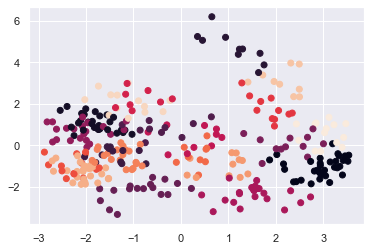

In [192]:
plt.scatter(category_sim_reduced[:,0],category_sim_reduced[:,1],c=kmeans.labels_);

In [193]:
category_grouped=pd.DataFrame(category_grouped)
category_grouped["label"]=kmeans.labels_

In [194]:
category_grouped[category_grouped["label"]==10].index

Index(['burrito', 'dip', 'enchilada', 'jalapeno', 'nacho', 'popper',
       'quesadilla', 'wonton'],
      dtype='object', name='Category')

#### Segment users depending on which recipe group they like

In [195]:
#Create a column with recipe group
recipes=recipes.merge(category_grouped.reset_index().drop("Ingredients_clean",axis=1),on="Category")
reviews=reviews.merge(recipes[["Recipe_ID","label"]],on="Recipe_ID")

In [196]:
#Create a dataframe with the number of recipes reviewed by user in each recipe group
user_category=reviews.groupby(["Reviewer_ID","label"]).size().reset_index().pivot(index="Reviewer_ID",columns="label",values=0).fillna(0)
user_category=user_category.divide(user_category.sum(axis=1),axis=0)
user_category.head()

label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Reviewer_ID,,,,,,,,,,,,,,,,,,,,
16,0.285714,0.000000,0.000000,0.000000,0.071429,0.071429,0.000000,0.142857,0.071429,0.000000,0.071429,0.071429,0.000000,0.071429,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000
22,0.480000,0.040000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.000000,0.000000,0.080000
32,0.295082,0.081967,0.016393,0.032787,0.016393,0.065574,0.049180,0.032787,0.081967,0.032787,0.000000,0.000000,0.016393,0.049180,0.081967,0.016393,0.114754,0.000000,0.000000,0.016393
39,0.081081,0.108108,0.011583,0.077220,0.015444,0.077220,0.019305,0.034749,0.046332,0.015444,0.011583,0.007722,0.073359,0.003861,0.073359,0.011583,0.277992,0.007722,0.015444,0.030888
44,0.000000,0.142857,0.000000,0.000000,0.142857,0.000000,0.285714,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000


In [197]:
#Apply pca
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(user_category)
user_category_reduced=pca.transform(user_category)

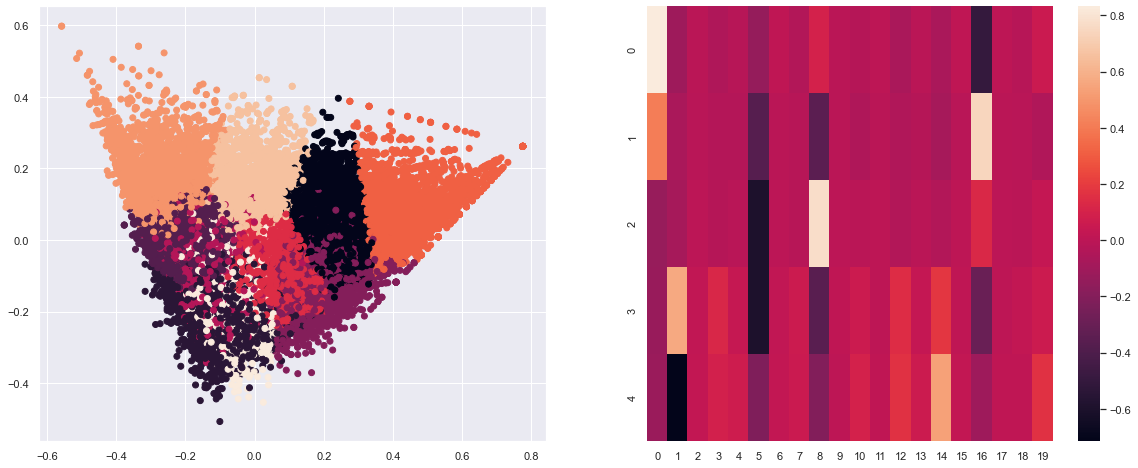

In [198]:
# apply kmeans on chosen number of clusters
fig,ax=plt.subplots(1,2,figsize=(20,8))

from sklearn.cluster import KMeans
n_labels=10
kmeans = KMeans(n_clusters=n_labels, random_state=0).fit(user_category_reduced)
ax[0].scatter(user_category_reduced[:,0],user_category_reduced[:,1],c=kmeans.labels_);
sns.heatmap(pca.components_,ax=ax[1]);

In [199]:
category_grouped[category_grouped["label"]==10].index

Index(['burrito', 'dip', 'enchilada', 'jalapeno', 'nacho', 'popper',
       'quesadilla', 'wonton'],
      dtype='object', name='Category')

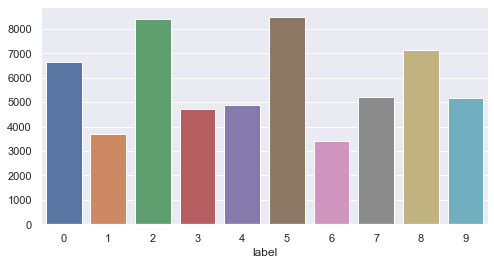

In [200]:
fig,ax=plt.subplots(figsize=(8,4))
sns.barplot(pd.DataFrame(kmeans.labels_,columns=["label"]).groupby("label").size().index,pd.DataFrame(kmeans.labels_,columns=["label"]).groupby("label").size());

In [201]:
#Create dataframe with the label of each user
user_labels=pd.DataFrame(kmeans.labels_,index=user_category.index,columns=["user_label"])
user_labels=reviews.merge(user_labels.reset_index(),on="Reviewer_ID")

In [202]:
user_labels.head()

,Recipe_ID,Reviewer_ID,Rating,Review,label,user_label
0,222388,8542392,5,"['best', 'breakfast', 'ever', 'ran', 'out', 'o...",14,7
1,84270,8542392,5,"['awesome', 'recipe', 'and', 'my', 'first', 't...",5,7
2,218070,8542392,5,"['this', 'is', 'the', 'best', 'pork', 'chop', ...",1,7
3,245062,8542392,5,"['this', 'is', 'great', 'recipe', 'what', 'an'...",0,7
4,213243,8542392,5,"['this', 'is', 'an', 'excellent', 'recipe', 'a...",16,7


In [222]:
plot_recipes(user_labels[user_labels["user_label"]==9].groupby("Recipe_ID").size().sort_values(ascending=False).index[0:10]);

In [224]:
plot_recipes(user_labels[user_labels["user_label"]==4].groupby("Recipe_ID").size().sort_values(ascending=False).index[0:10]);

In [225]:
plot_recipes(user_labels[user_labels["user_label"]==8].groupby("Recipe_ID").size().sort_values(ascending=False).index[0:10]);

### Content-base recipe retrieval with TFIDF (using recipe instructions)

In [206]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity
from gensim.corpora import Dictionary
import numpy as np

In [207]:
#Define Dictionary of Ingredients
dictionary = Dictionary(recipes["Instructions"])

#Fiter Ingredients that appear in at least 10 recipes
dictionary.filter_extremes(no_below=100,no_above=0.5)

len(dictionary)

bow_corpus = [dictionary.doc2bow(ingredients) for ingredients in recipes["Instructions"]]
model=TfidfModel(bow_corpus)
index = MatrixSimilarity(bow_corpus, num_features=len(dictionary))

In [217]:
plot_recipes(index_to_id(index[bow_corpus[900]].argsort()[-10:][::-1]));

In [229]:
plot_recipes(index_to_id(index[bow_corpus[300]].argsort()[-10:][::-1]));

### K-Neighbors User-User Collaborative filtering recommender system

In [86]:
#load reviews
reviews=pd.read_csv("reviews_clean.csv")
reviews=reviews.dropna()

#load recipes
recipes=pd.read_csv("recipes_clean.csv")

#Convert ingredient and ingredient strings into ingredient lists
recipes["Ingredients_clean"]=recipes["Ingredients_clean"].apply(eval)
recipes["Ingredients_clean"]=recipes["Ingredients_clean"].apply(lambda x : list(set(x)))
recipes["Instructions"]=recipes["Instructions"].apply(lambda x : simple_preprocess(" ".join(eval(x))))

In [87]:
#Keep only recipes with more than 30 reviews
mask=reviews.groupby("Recipe_ID").size()[(reviews.groupby("Recipe_ID").size()>200)].index
reviews=reviews[reviews["Recipe_ID"].isin(mask)]
recipes=recipes[recipes["Recipe_ID"].isin(reviews["Recipe_ID"].unique())]

In [88]:
#Keep only users with more than 10 reviews
mask=reviews.groupby("Reviewer_ID").size()[(reviews.groupby("Reviewer_ID").size()>10)].index
reviews=reviews[reviews["Reviewer_ID"].isin(mask)]
recipes=recipes[recipes["Recipe_ID"].isin(reviews["Recipe_ID"].unique())]

In [89]:
len(reviews["Recipe_ID"].unique())

3748

In [90]:
len(reviews["Reviewer_ID"].unique())

34267

In [91]:
#Create user-item sparse pivot matrix

def create_user_item_matrix(reviews) : 
    

    from scipy.sparse import csr_matrix
    from pandas.api.types import CategoricalDtype

    user_c = CategoricalDtype(sorted(reviews["Reviewer_ID"].unique()), ordered=True)
    item_c = CategoricalDtype(sorted(reviews["Recipe_ID"].unique()), ordered=True)

    row = reviews["Reviewer_ID"].astype(user_c).cat.codes
    col = reviews["Recipe_ID"].astype(item_c).cat.codes

    user_item = csr_matrix((reviews["Rating"], (row, col)), 
                                         shape=(user_c.categories.size, item_c.categories.size))
    
    return user_item.astype("float")

def compute_user_similarities(user_item) : 

    # Compute user-user cosine similarity matrix 
    from sklearn.metrics.pairwise import cosine_similarity
    user_similarities = cosine_similarity(user_item,dense_output=False)    
    return user_similarities

def get_similar_users(user, user_similarities,k) :
    
    return (user_similarities[user].toarray().flatten()[user_similarities[user].toarray().argsort()[0][-k:-1]],
            user_similarities[user].toarray().argsort()[0][-k:-1])

def predict_user_ratings(user,similar_users,weights,user_item) :   
    
    user_ratings_pred= ((weights.reshape(1,weights.shape[0])*user_item[similar_users])/weights.sum()) 
     
    return  user_ratings_pred 

def top_n_recommendations(user,user_ratings_pred,n=10) :
    
    user_ratings_pred=np.delete(user_ratings_pred,user_item[user].nonzero()[1])
    
    return user_ratings_pred.argsort()[-n:]

def get_recommendations(user,user_similarities,user_item_matrix, k=20,n=10) :
    
    weights,similar_users=get_similar_users(user,user_similarities,k)
    user_ratings_pred=predict_user_ratings(user,similar_users,weights,user_item)
    
    return top_n_recommendations(user,user_ratings_pred,n)

In [92]:
user_item=create_user_item_matrix(reviews)
user_similarities=compute_user_similarities(user_item)

In [93]:
plot_recipes(recipes["Recipe_ID"].iloc[get_recommendations(58,user_similarities,user_item)].values);

In [94]:
from sklearn.model_selection import train_test_split
reviews_train,reviews_test=train_test_split(reviews,test_size=0.45,stratify=reviews[["Reviewer_ID"]])

In [95]:
len(reviews_test["Reviewer_ID"].unique())

34267

In [96]:
len(reviews_test["Recipe_ID"].unique())

3748

In [97]:
#Create train item-user and user-item matrices
user_item_train=create_user_item_matrix(reviews_train)

#Create test item-user and user-item matrices
user_item_test=create_user_item_matrix(reviews_test)

#scale item-user matrix 
user_mean_rating=np.array(reviews_train.groupby("Reviewer_ID")["Rating"].mean())
nz = user_item_train.nonzero()
user_item_train_scaled=user_item_train.copy()
user_item_train_scaled[user_item_train_scaled.nonzero()] -= user_mean_rating[nz[0]]

In [98]:
user_similarities_train=compute_user_similarities(user_item_train_scaled)

In [99]:
users=np.arange(len(reviews["Reviewer_ID"].unique()))
predictions=[]
for user in users :
    weights,similar_users=get_similar_users(user, user_similarities_train,5)
    user_pred=((user_item_train_scaled[similar_users].toarray().T.dot(weights))+user_mean_rating[user])
    #user_pred[user_pred>5]=5
    #user_pred[user_pred<1]=1
    predictions.append(user_pred)

In [100]:
predictions=np.array(predictions)

In [101]:
#baseline MAE evaluation
nz = user_item_test.nonzero()
np.mean((np.abs(user_item_test[nz][0]-user_mean_rating[nz[0]])))

#Item item collaborative filtering MAE evaluation
np.mean(np.abs(user_item_test[nz][0]-predictions[nz]))

0.5605346846476642

In [102]:
sorted_predictions=predictions.argsort()
recommended_recipes=pd.DataFrame(sorted_predictions[:,-1:].flatten()).groupby(0).size().sort_values(ascending=False)

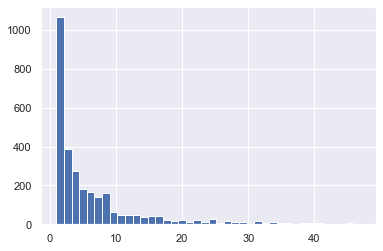

In [103]:
plt.hist(recommended_recipes[100:],bins=40);

In [120]:
plot_recipes(recipes["Recipe_ID"].iloc[sorted_predictions[:,-20:-10][1400]].values);

In [ ]:
### Collaborative filtering with matrix factorization 

In [ ]:
from sklearn.model_selection import train_test_split
Recipe_ids_train,Recipe_ids_test=train_test_split(recipes["Recipe_ID"],test_size=0.25,random_state=42)

reviews_train=reviews[reviews["Recipe_ID"].isin(Recipe_ids_train)]
reviews_test=reviews[reviews["Recipe_ID"].isin(Recipe_ids_test)]

from scipy.sparse.linalg import svds
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

U, sigma, Vt = svds(user_item.asfptype(), k = NUMBER_OF_FACTORS_MF)

U.shape

all_user_predicted_ratings = np.dot(np.dot(U,np.diag(sigma)),Vt )

#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_reviews_pivot_matrix.columns, index=users_reviews_pivot_matrix.index).transpose()
cf_preds_df[240].sort_values(ascending=False).index[:10]
cf_preds_df

plot_recipes(cf_preds_df[521].sort_values(ascending=False).index[:20]);
plot_recipes(cf_preds_df[22079061].sort_values(ascending=False).index[:20]);

In [251]:
import shutil, os

tasty_images=[]
for recipe_ID in recipe_index:
    tasty_images.append("Images/{}.jpg".format(recipe_ID))
    
for f in tasty_images:
    shutil.copy(f, 'Im') 

In [252]:
import PIL
from PIL import Image


for recipe_ID in recipe_index :
    basewidth = 100
    img = Image.open("Im/{}.jpg".format(recipe_ID))
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
    img.save("Im2/{}.jpg".format(recipe_ID))